<a href="https://colab.research.google.com/github/01PrathamS/image_generation_RUST/blob/main/notebooks/reconstruction_faces_VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install ultralytics datasets --upgrade -q
!pip install datasets transformers kaggle

In [ ]:

import os
os.environ["KAGGLE_CONFIG_DIR"] = "/content"

In [ ]:
!kaggle datasets download -d lylmsc/wider-face-for-yolo-training
!unzip wider-face-for-yolo-training.zip

In [ ]:
from ultralytics import YOLO
import cv2
import os
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image
from tqdm import tqdm
import torch

# Set paths to your custom dataset
image_folder = "images"
output_folder = "cropped_faces"
os.makedirs(output_folder, exist_ok=True)

# Load model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model = YOLO("yolov11m-face.pt")  # Adjust path to your model if needed
model.to(device)

# Image files (sorted to maintain order)
image_files = sorted([f for f in os.listdir(image_folder) if f.lower().endswith(('.jpg', '.png'))])

cropped_faces = []
num_samples = min(1000, len(image_files))  # Limit number of images
scale = 2.5  # Adjust padding

for idx in tqdm(range(num_samples), desc="Processing images"):
    image_path = os.path.join(image_folder, image_files[idx])
    image = Image.open(image_path).convert("RGB")
    image_np = np.array(image)
    h, w = image_np.shape[:2]

    # Run inference
    results = model.predict(source=image_np, verbose=False, device=device.index if device.type == "cuda" else None)
    boxes = results[0].boxes.xyxy.cpu().numpy() if results[0].boxes is not None else []

    if len(boxes) == 0:
        continue

    # Choose most centered face
    image_center = np.array([w / 2, h / 2])
    best_box = min(
        boxes,
        key=lambda box: np.linalg.norm(image_center - [(box[0] + box[2]) / 2, (box[1] + box[3]) / 2])
    )

    x1, y1, x2, y2 = best_box
    box_w = x2 - x1
    box_h = y2 - y1
    center_x = (x1 + x2) / 2
    center_y = (y1 + y2) / 2

    # Scale the bounding box
    new_w = box_w * scale
    new_h = box_h * scale
    x1_new = max(0, int(center_x - new_w / 2))
    y1_new = max(0, int(center_y - new_h / 2))
    x2_new = min(w, int(center_x + new_w / 2))
    y2_new = min(h, int(center_y + new_h / 2))

    # Crop face and save
    face_crop = image_np[y1_new:y2_new, x1_new:x2_new]
    output_path = os.path.join(output_folder, f"face_{idx}.jpg")
    cv2.imwrite(output_path, cv2.cvtColor(face_crop, cv2.COLOR_RGB2BGR))
    cropped_faces.append(face_crop)

# # --- Optional visualization ---
# cols = 10
# rows = (len(cropped_faces) + cols - 1) // cols
# fig, axes = plt.subplots(rows, cols, figsize=(20, 2 * rows))

# for i in range(rows * cols):
#     ax = axes[i // cols, i % cols]
#     if i < len(cropped_faces):
#         ax.imshow(cropped_faces[i])
#         ax.axis("off")
#     else:
#         ax.remove()

# plt.tight_layout()
# plt.show()


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Using device: cuda


Processing images: 100%|██████████| 1000/1000 [00:40<00:00, 24.77it/s]


In [ ]:
import os
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from PIL import Image

# Path to image folder
images_folder_path = "cropped_faces"

# Transforms
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

from torch.utils.data import Dataset, DataLoader
from PIL import Image
import os

class UnlabeledImageDataset(Dataset):
    def __init__(self, folder_path, transform=None):
        self.folder_path = folder_path
        self.image_paths = [
            os.path.join(folder_path, fname)
            for fname in os.listdir(folder_path)
            if fname.lower().endswith(('.png', '.jpg', '.jpeg'))
        ]
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert("RGB")  # Grayscale; use "RGB" if needed
        if self.transform:
            image = self.transform(image)
        return image


images_folder_path = "/content/cropped_faces"
dataset = UnlabeledImageDataset(images_folder_path, transform=transform)
train_loader = DataLoader(dataset, batch_size=32, shuffle=True)


In [ ]:

# Loss function
def loss_function(recon_x, x, mu, logvar):
    recon_loss = nn.functional.mse_loss(recon_x, x, reduction="sum")
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kl_loss

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

def init_weights(m):
    if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.Linear)):
        nn.init.kaiming_normal_(m.weight, nonlinearity='relu')  # Good for ReLU activations
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)

class VAE(nn.Module):
    def __init__(self, latent_dim=128):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim

        # Encoder: Convolutional
        self.encoder_cnn = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1),  # (64, 64, 64)
            nn.ReLU(),
            nn.Conv2d(64, 128, 4, 2, 1),  # (128, 32, 32)
            nn.ReLU(),
            nn.Conv2d(128, 256, 4, 2, 1),  # (256, 16, 16)
            nn.ReLU(),
            nn.Conv2d(256, 512, 4, 2, 1),  # (512, 8, 8)
            nn.ReLU(),
            nn.Flatten()  # 512*8*8 = 32768
        )
        self.fc_mu = nn.Linear(512 * 8 * 8, latent_dim)
        self.fc_logvar = nn.Linear(512 * 8 * 8, latent_dim)

        # Decoder: Fully connected + Deconv
        self.decoder_fc = nn.Linear(latent_dim, 512 * 8 * 8)

        self.decoder_deconv = nn.Sequential(
            nn.ConvTranspose2d(512, 256, 4, 2, 1),  # (256, 16, 16)
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, 4, 2, 1),  # (128, 32, 32)
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 4, 2, 1),  # (64, 64, 64)
            nn.ReLU(),
            nn.ConvTranspose2d(64, 3, 4, 2, 1),    # (3, 128, 128)
            nn.Sigmoid()  # Output in [0, 1]
        )

        # 🔥 Apply weight initialization to all submodules
        self.apply(init_weights)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        x = self.encoder_cnn(x)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        z = self.reparameterize(mu, logvar)
        x = self.decoder_fc(z).view(-1, 512, 8, 8)
        return self.decoder_deconv(x), mu, logvar

    def generate_from_embedding(self, embedding):
        x = self.decoder_fc(embedding).view(-1, 512, 8, 8)
        return self.decoder_deconv(x)


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize model
vae = VAE(latent_dim=128).to(device)
optimizer = optim.Adam(vae.parameters(), lr=0.001)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    epoch_loss = 0
    for images in train_loader:
        images = images.to(device)  # shape: (B, 3, 128, 128)
        optimizer.zero_grad()
        recon_images, mu, logvar = vae(images)
        loss = loss_function(recon_images, images, mu, logvar)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.2f}")

Epoch [1/10], Loss: 4326357.25
Epoch [2/10], Loss: 3065722.91
Epoch [3/10], Loss: 2562437.71
Epoch [4/10], Loss: 2065759.79
Epoch [5/10], Loss: 1707194.39
Epoch [6/10], Loss: 1504059.68
Epoch [7/10], Loss: 1379187.70
Epoch [8/10], Loss: 1328569.47
Epoch [9/10], Loss: 1230426.58
Epoch [10/10], Loss: 1154316.40


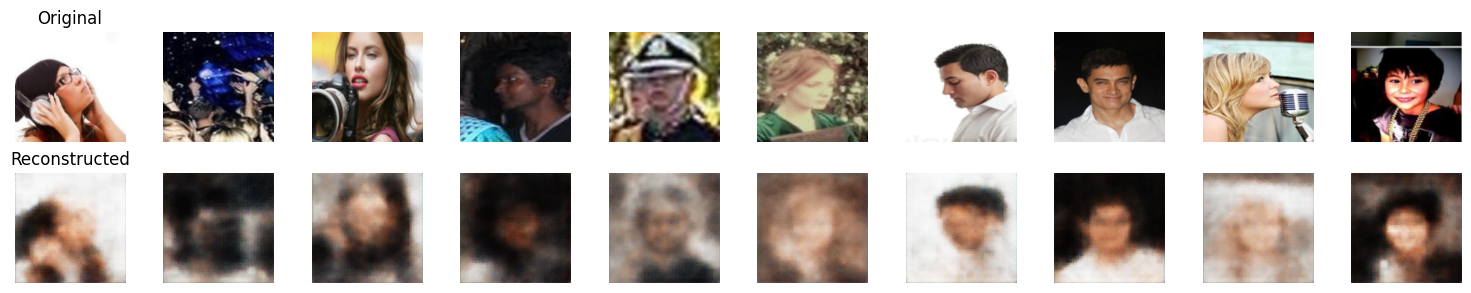

In [ ]:
# Test reconstruction
test_images = next(iter(train_loader)).to(device)  # shape: (B, 3, 128, 128)

with torch.no_grad():
    reconstructed, _, _ = vae(test_images)

# Move to CPU for plotting
test_images = test_images.cpu()
reconstructed = reconstructed.cpu()

# Plot original vs reconstructed
fig, axes = plt.subplots(2, 10, figsize=(15, 3))
for i in range(10):
    axes[0, i].imshow(test_images[i].permute(1, 2, 0))  # (3, H, W) -> (H, W, 3)
    axes[1, i].imshow(reconstructed[i].permute(1, 2, 0))
    axes[0, i].axis('off')
    axes[1, i].axis('off')

axes[0, 0].set_title("Original")
axes[1, 0].set_title("Reconstructed")
plt.tight_layout()
plt.show()


In [ ]:
# Test reconstruction
test_images = next(iter(train_loader)).to(device)  # shape: (B, 3, 128, 128)

with torch.no_grad():
    reconstructed, _, _ = vae(test_images)

# Move tensors to CPU for plotting
test_images = test_images.cpu()
reconstructed = reconstructed.cpu()

# Number of pairs to display
num_images = 10

# Create a figure with one row per pair (original, reconstructed)
fig, axes = plt.subplots(num_images, 2, figsize=(8, 4*num_images))

for i in range(num_images):
    # Plot original image on left
    axes[i, 0].imshow(test_images[i].permute(1, 2, 0))
    axes[i, 0].set_title("Original")
    axes[i, 0].axis('off')

    # Plot reconstructed image on right
    axes[i, 1].imshow(reconstructed[i].permute(1, 2, 0))
    axes[i, 1].set_title("Reconstructed")
    axes[i, 1].axis('off')

plt.tight_layout()
plt.show()


In [ ]:
torch.save(vae.state_dict(), "vae_weights.pth")


# vae = VAE(latent_dim=128)
# # Load the saved weights
# vae.load_state_dict(torch.load("vae_weights.pth"))
# # Move model to GPU if needed:
# vae.to(device)